<h1 style='color: green; font-size: 36px; font-weight: bold;'>Data Science - Regressão Linear</h1>

# <font color='red' style='font-size: 30px;'>Estudo de caso: Modelo de regressão linear de preços de aluguéis em São Paulo</font>
<hr style='border: 2px solid red;'>

## Importando bibliotecas

In [32]:
import pandas as pd
from unidecode import unidecode
import re

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings 
warnings.filterwarnings('ignore')

import pickle

from sklearn.preprocessing import LabelEncoder

## O Dataset e o Projeto
<hr>

### Fonte: https://drive.google.com/file/d/1DcS1VgGGVa5O6JHuD7ZeKmxgI1ejCw4m/view

### Descrição:
<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>Nosso objetivo neste código é criar um modelo de machine learning, utilizando a técnica de Regressão Linear, que faça previsões sobre os preços de aluguéis em São Paulo a partir de um conjunto de características conhecidas dos imóveis.</p>

<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>Vamos utilizar um dataset disponibilizado pela plataforma Alura em formato de csv pelo Google Drive. O objetivo é aprender a importar dados, limpar, explorar, visualizar e tirar conclusões a partir dos dados, além de ajustar um modelo de regressão linear e avaliar seu desempenho.</p>

### Dados:
<ul style='font-size: 18px; line-height: 2; text-align: justify;'>
    <li><b>adress</b> - Rua do imóvel</li>
    <li><b>district</b> - Bairro do imóvel</li>
    <li><b>area</b> - Área do imóvel</li>
    <li><b>bedrooms</b> - Número de quartos</li>
    <li><b>garage</b> - Número de vagas de garagem</li>
    <li><b>type</b> - Classificação do tipo de imóvel</li>
    <li><b>rent</b> - Preço do aluguel(R$)</li>
    <li><b>total</b> - Preço final do aluguel(R$)</li>
</ul>

## Leitura dos dados

In [4]:
dados = pd.read_csv('../Dados/base-alugueis-sp.csv', sep = ',')

## Visualizar os dados

In [4]:
dados.head()

,address,district,area,bedrooms,garage,type,rent,total
0,Rua Herval,Belenzinho,21,1,0,Studio e kitnet,2400,2939
1,Avenida São Miguel,Vila Marieta,15,1,1,Studio e kitnet,1030,1345
2,Rua Oscar Freire,Pinheiros,18,1,0,Apartamento,4000,4661
3,Rua Júlio Sayago,Vila Ré,56,2,2,Casa em condomínio,1750,1954
4,Rua Barata Ribeiro,Bela Vista,19,1,0,Studio e kitnet,4000,4654


## Verificando o tamanho do dataset

In [5]:
dados.shape

(11657, 8)

# <font color='red' style='font-size: 30px;'>Análises Preliminares</font>
<hr style='border: 2px solid red;'>

## Estatísticas descritivas

In [6]:
dados.describe().round(2)

,area,bedrooms,garage,rent,total
count,11657.00,11657.00,11657.00,11657.00,11657.00
mean,84.66,1.97,1.06,3250.81,4080.03
std,74.02,0.93,1.13,2650.71,3352.48
min,0.00,0.00,0.00,500.00,509.00
25%,40.00,1.00,0.00,1590.00,1996.00
50%,60.00,2.00,1.00,2415.00,3057.00
75%,96.00,3.00,2.00,3800.00,4774.00
max,580.00,6.00,6.00,25000.00,28700.00


Acima verificamos que: 

- A maioria dos imóveis possui 1 e 2 quartos, com máximo em 6;
- Os menores alugueis totais estão em R$ 509,60 (baixo mas não anormal);
- Os maiores alugueis totais são R$ 28.700,00 (dentro da normalidade);

Entre as outras estatísticas que também apresentam certa normalidade, mas que serão melhores exploradas graficamente mais a frente. 



### Verificação se há ou não dados nulos, e se seus types estão de acordo

In [7]:
print(dados.info())
print(dados.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   address   11657 non-null  object
 1   district  11657 non-null  object
 2   area      11657 non-null  int64 
 3   bedrooms  11657 non-null  int64 
 4   garage    11657 non-null  int64 
 5   type      11657 non-null  object
 6   rent      11657 non-null  int64 
 7   total     11657 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 728.7+ KB
None
address     0
district    0
area        0
bedrooms    0
garage      0
type        0
rent        0
total       0
dtype: int64


## Matriz de correlação

<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>O <b>coeficiente de correlação</b> é uma medida de associação linear entre duas variáveis e situa-se entre <b>-1</b> e <b>+1</b> sendo que <b>-1</b> indica associação negativa perfeita e <b>+1</b> indica associação positiva perfeita.</p>


In [12]:
corr = dados.select_dtypes(include=['number']).corr().round(4)
corr

,area,bedrooms,garage,rent,total
area,1.0000,0.7279,0.7334,0.6672,0.6521
bedrooms,0.7279,1.0000,0.6569,0.5312,0.5260
garage,0.7334,0.6569,1.0000,0.6173,0.6180
rent,0.6672,0.5312,0.6173,1.0000,0.9781
total,0.6521,0.5260,0.6180,0.9781,1.0000


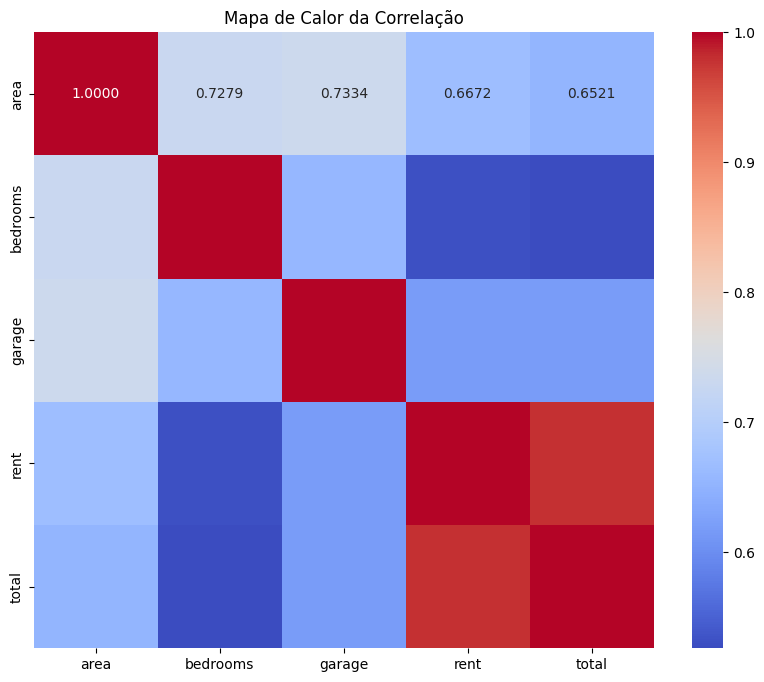

In [13]:
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, fmt=".4f", cmap='coolwarm')
heatmap.set_title('Mapa de Calor da Correlação')
plt.show()

In [1]:
import seaborn as sns
import matplotlib as mpl
import pandas as pd

print("Seaborn version:", sns.__version__)
print("Matplotlib version:", mpl.__version__)
print("Pandas version:", pd.__version__)

Seaborn version: 0.12.2
Matplotlib version: 3.9.0
Pandas version: 2.2.2


### Observe as correlações entre as variáveis:
<ul style='font-size: 16px; line-height: 2; text-align: justify;'>
    <li>Quais são mais correlacionadas com a variável dependete (total)?</li>
        R: Todas apresentam um relacionamento forte com a variável dependente.
    <li>Qual o relacionamento entre elas (positivo ou negativo)?</li>
        R: Positivo, ou seja, as variáveis "caminham" em mesma direção, se a explicativa aumenta, a dependente também aumenta.
    <li>Existe correlação forte entre as variáveis explicativas?</li>
        R: A variável rent pode causar conflito na estimação do modelo devido sua forte correlação com as outras variáveis explicativas.
</ul>

# <font color='red' style='font-size: 30px;'>Comportamento da Variável Dependente (Y)</font>
<hr style='border: 2px solid red;'>

# Análises gráficas

<img width='700px' src='../Dados/img/Box-Plot.png'>

In [17]:
# configurando o estilo dos graficos
sns.set_palette("Accent")

sns.set_style("darkgrid")

## Box plot da variável *dependente* (y)


https://seaborn.pydata.org/generated/seaborn.boxplot.html?highlight=boxplot#seaborn.boxplot

In [114]:
dados.describe()

,area,bedrooms,garage,rent,total,district_encoded
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625,568.803895
std,74.020536,0.931313,1.132349,2650.711557,3352.480274,368.193604
min,0.000000,0.000000,0.000000,500.000000,509.000000,0.000000
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000,166.000000
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000,647.000000
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000,875.000000
max,580.000000,6.000000,6.000000,25000.000000,28700.000000,1198.000000


<Axes: title={'center': 'Preços totais de alugueis (R$)'}, xlabel='$'>

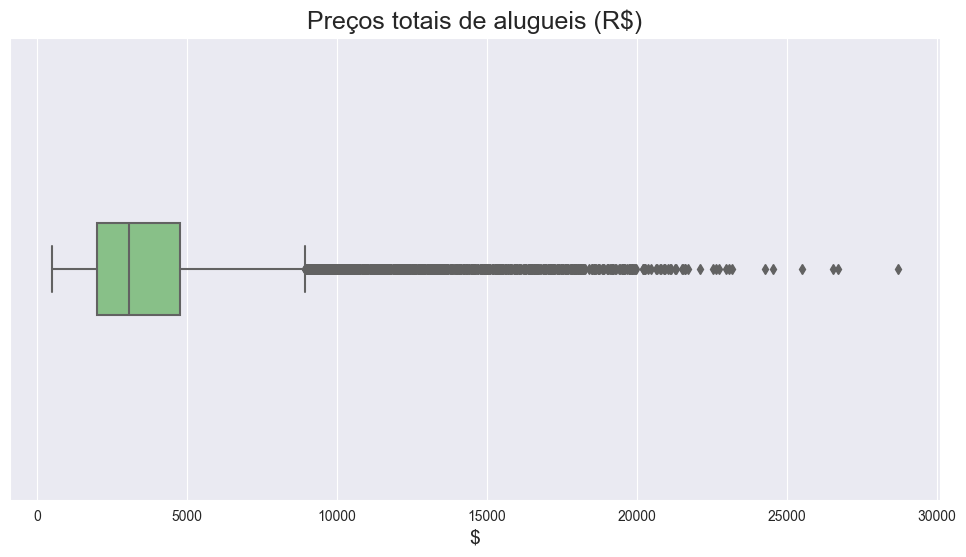

In [118]:
ax = sns.boxplot(x='total', data = dados, orient = 'h', width = 0.2)
ax.figure.set_size_inches(12, 6)
ax.set_title('Preços totais de alugueis (R$)', fontsize=18)
ax.set_xlabel('$', fontsize=14)
ax

### Avalie o comportamento da distribuição da variável dependente:
<ul style='font-size: 16px; line-height: 2; text-align: justify;'>
    <li>Parecem existir valores discrepantes (outliers)?</li>
    R: Há dados além dos limites mas parece ser coerente dentro dos valores de aluguel em SP, a depender do tipo de imóvel.
    <li>O box plot apresenta alguma tendência?</li>
    R: Sim, parece apresentar uma assimetria a direita, onde os valores de alugueis se concentram em valores mais baixos.
</ul>

## Investigando a variável *dependente* (y) juntamente com outras variáveis (somente as categóricas).

### Box-plot

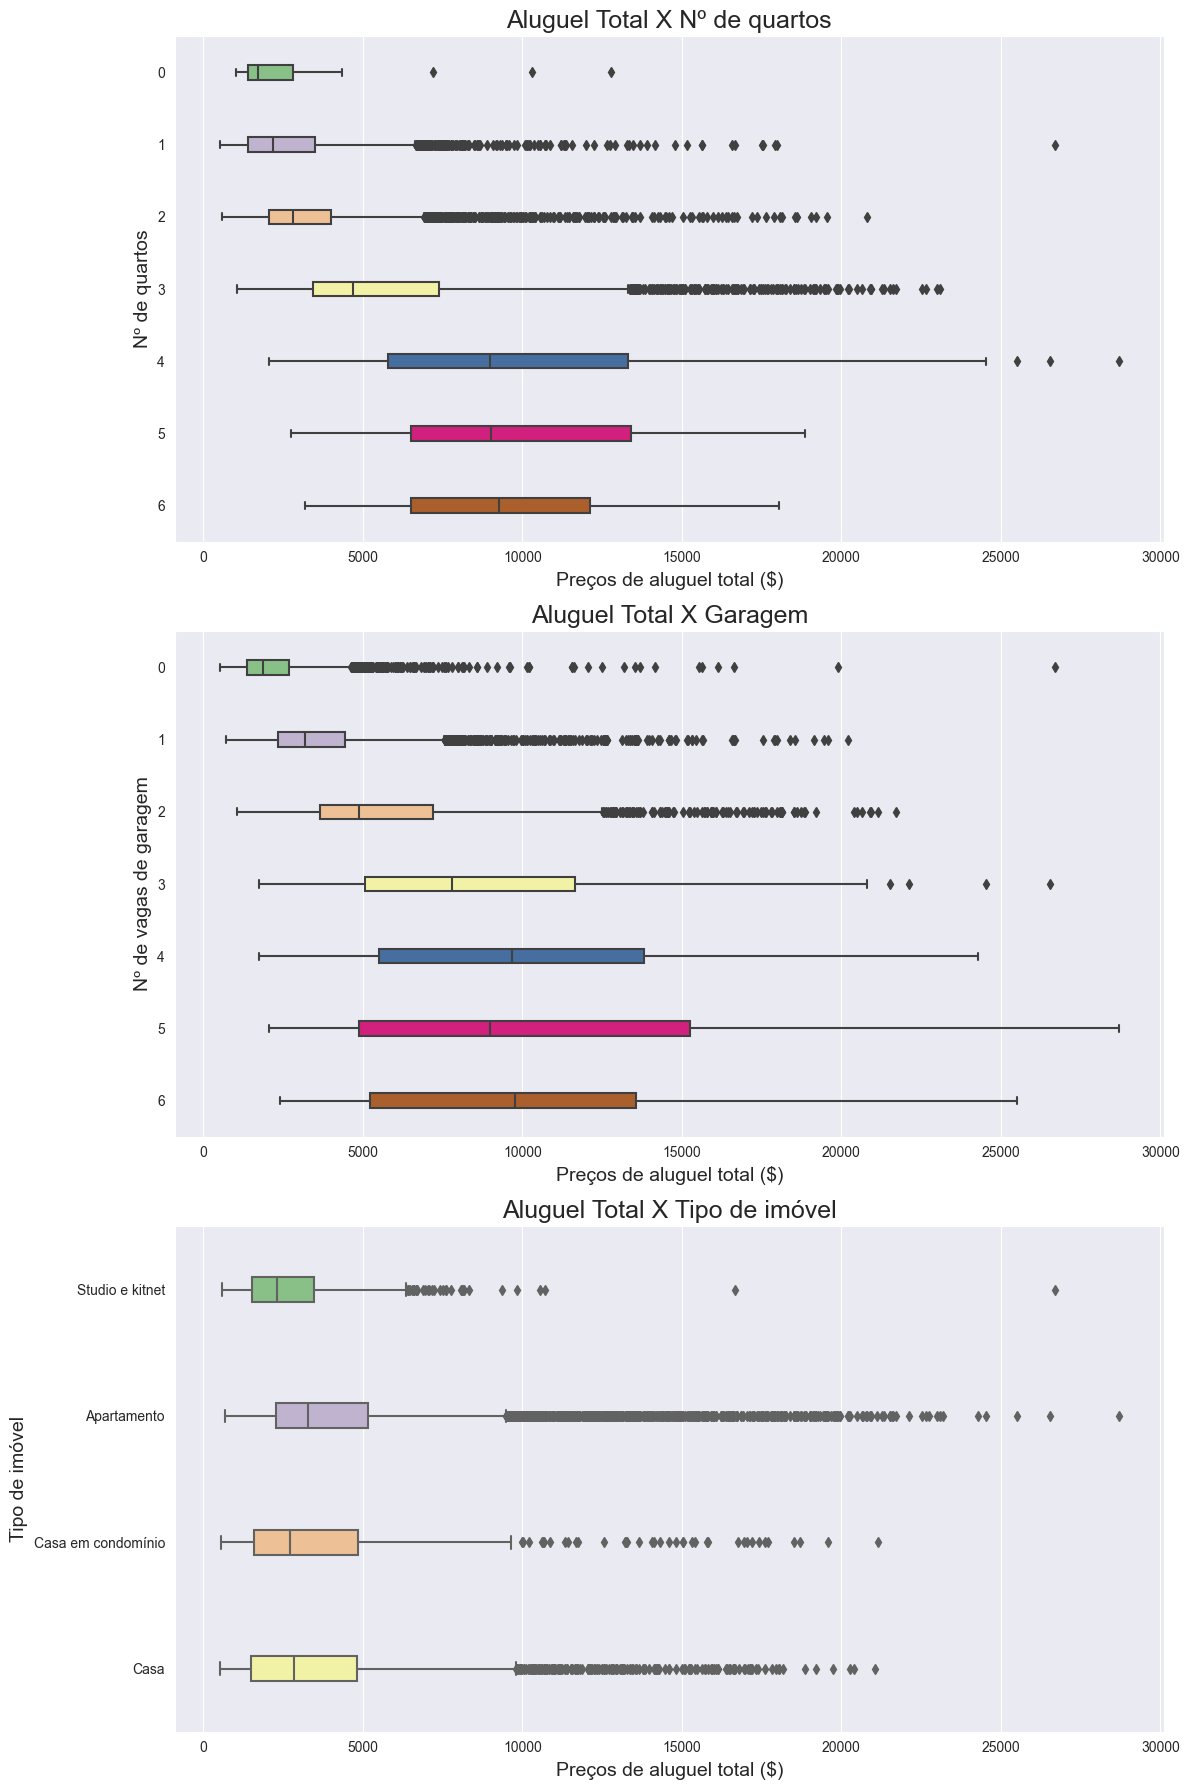

In [119]:
fig, ax = plt.subplots(3,1, figsize=(12, 18))

# Aluguel Total X Nº de quartos
sns.boxplot(x='total', y= 'bedrooms', data = dados, orient = 'h', width = 0.2, ax=ax[0])
ax[0].set_title('Aluguel Total X Nº de quartos', fontsize=18)
ax[0].set_xlabel('Preços de aluguel total ($)', fontsize=14)
ax[0].set_ylabel('Nº de quartos', fontsize=14)

# Aluguel Total X Garagem
sns.boxplot(x='total', y='garage', data = dados, orient='h', width=0.2, ax=ax[1])
ax[1].set_title('Aluguel Total X Garagem', fontsize=18)
ax[1].set_xlabel('Preços de aluguel total ($)', fontsize=14)
ax[1].set_ylabel('Nº de vagas de garagem', fontsize=14)


# Aluguel Total X Tipo de imóvel
sns.boxplot(x='total', y='type', data = dados, orient='h', width=0.2, ax=ax[2])
ax[2].set_title('Aluguel Total X Tipo de imóvel', fontsize=18)
ax[2].set_xlabel('Preços de aluguel total ($)', fontsize=14)
ax[2].set_ylabel('Tipo de imóvel', fontsize=14)

plt.tight_layout()

plt.show()

<Axes: title={'center': 'Aluguel Total X Bairros'}, xlabel='Preços de aluguel total ($)', ylabel='Bairros'>

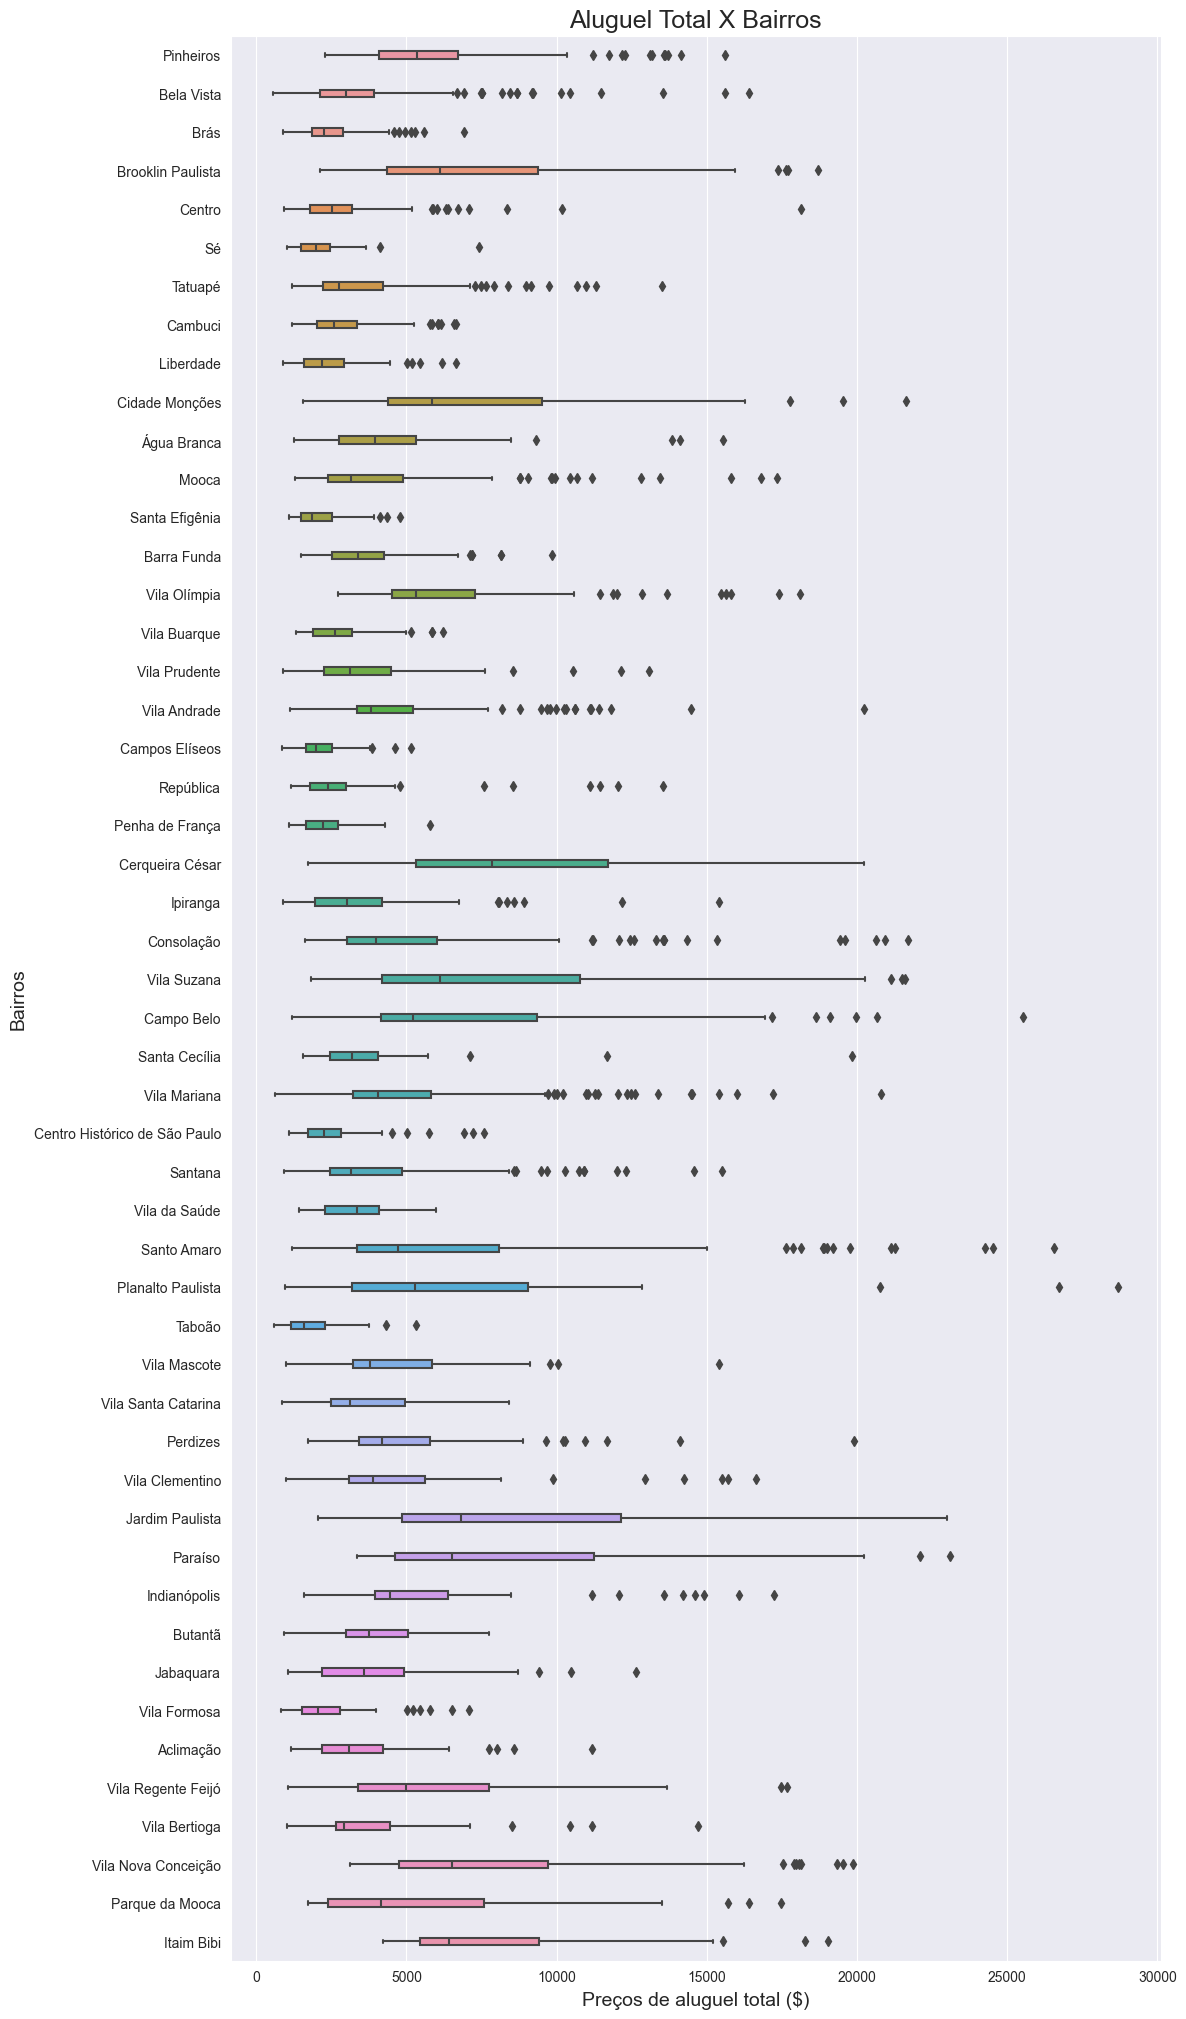

In [121]:
top_50_bairros = dados['district'].value_counts().nlargest(50).index
query_str = 'district in @top_50_bairros'
dados_top_50 = dados.query(query_str)

ax = sns.boxplot(x='total', y='district', data=dados_top_50, orient = 'h', width = 0.2)
ax.figure.set_size_inches(12, 25)
ax.set_title('Aluguel Total X Bairros', fontsize=18)
ax.set_xlabel('Preços de aluguel total ($)', fontsize=14)
ax.set_ylabel('Bairros', fontsize=14)
ax

<Axes: title={'center': 'Distribuição de area'}, xlabel='Area (m²)', ylabel='Density'>

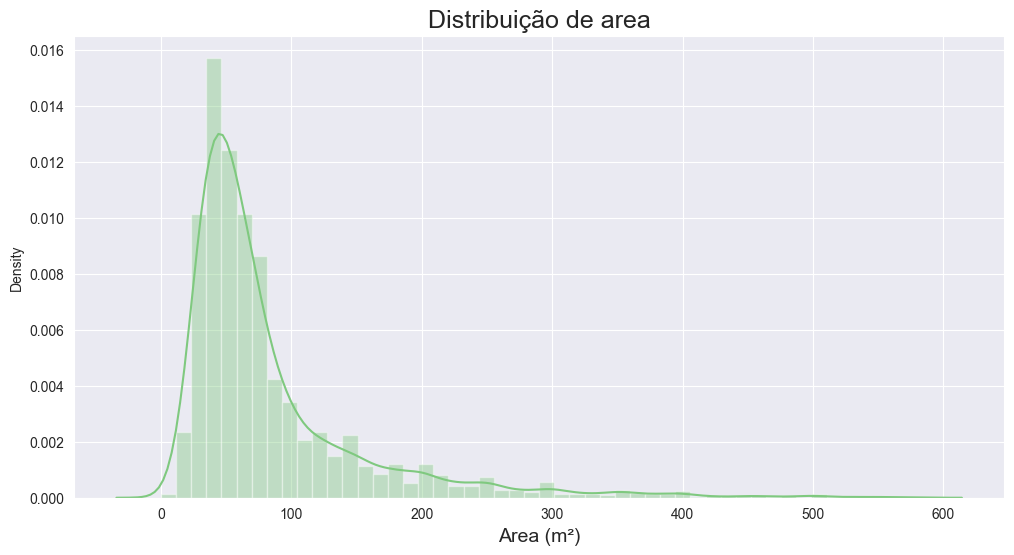

In [122]:
ax = sns.distplot(dados['area'], kde = True)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de area', fontsize=18)
ax.set_xlabel('Area (m²)', fontsize=14)
ax

## Distribuição de frequências da variável *dependente* (y)

### Avalie:
<ul style='font-size: 16px; line-height: 2; text-align: justify;'>
    <li>A distribuição de frequências da variável dependente parece ser assimétrica?</li>
    R: Sim, para a direita
    <li>É possível supor que a variável dependente segue uma distribuição normal?</li>
    R: Sim.
</ul>

https://seaborn.pydata.org/generated/seaborn.distplot.html?highlight=distplot#seaborn.distplot

<Axes: title={'center': 'Distribuição de alugueis totais'}, xlabel='Aluguel total de imóveis (R$)', ylabel='Density'>

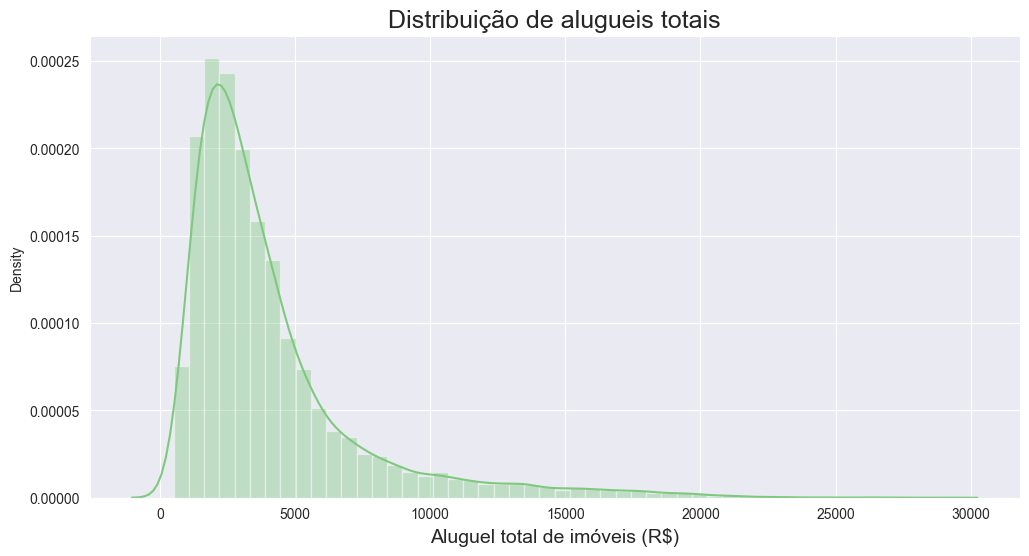

In [123]:
ax = sns.distplot(dados['total'], kde = True)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de alugueis totais', fontsize=18)
ax.set_xlabel('Aluguel total de imóveis (R$)', fontsize=14)
ax

## Gráficos de dispersão entre as variáveis do dataset

<img width='700px' src='../Dados/img/var_u.jpg'>

## Plotando o pairplot fixando somente uma variável no eixo y

Gráficos de dispersão da variável dependente contra cada variável explicativa.

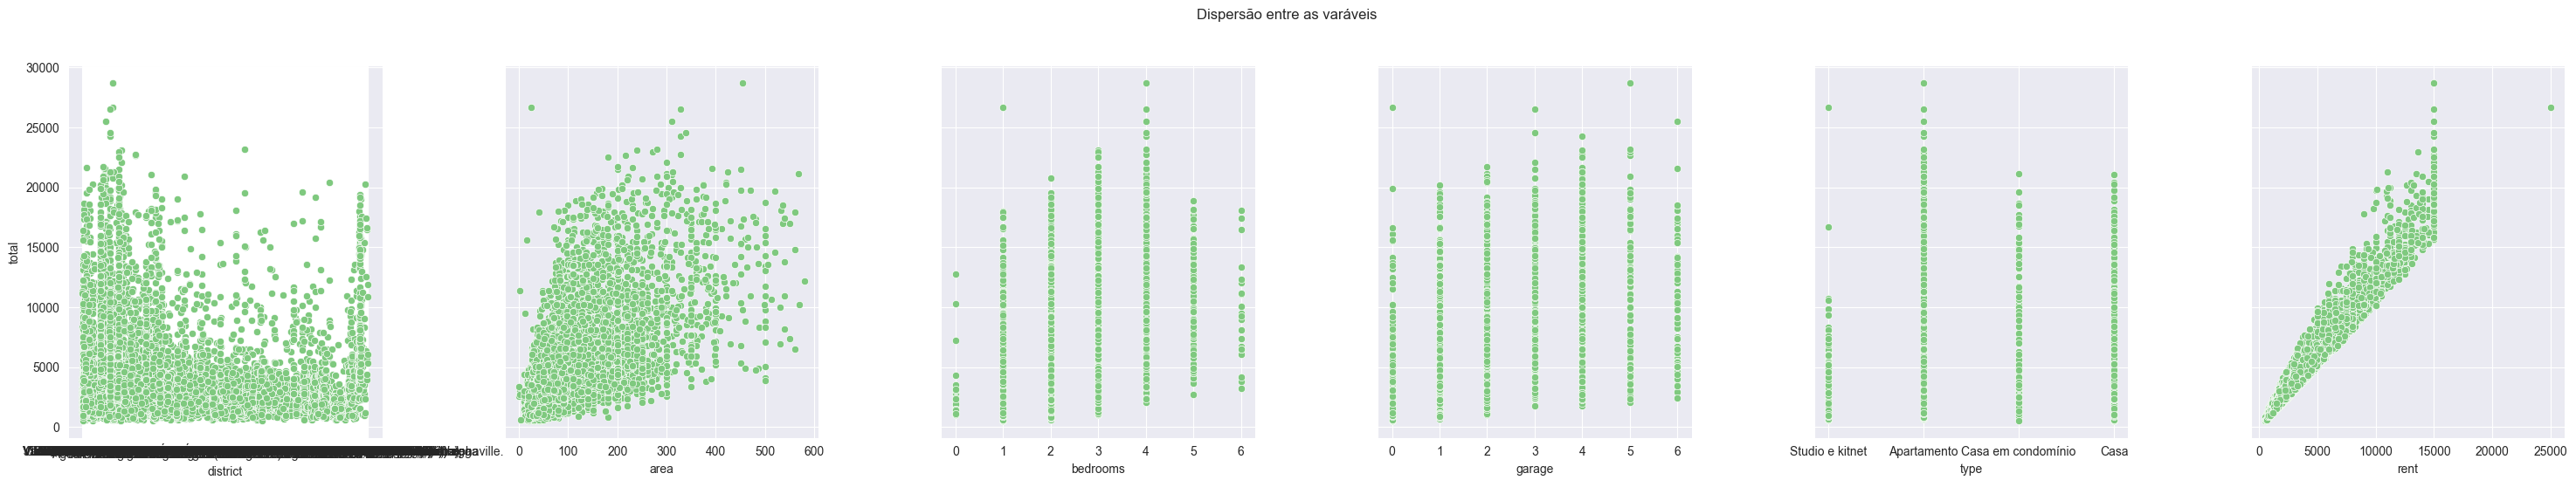

In [124]:
ax = sns.pairplot(dados, y_vars = 'total', x_vars = ['district', 'area', 'bedrooms', 'garage', 'type', 'rent'], height=5)
plt.suptitle('Dispersão entre as varáveis', fontsize = 12, y = 1.1)
plt.show()

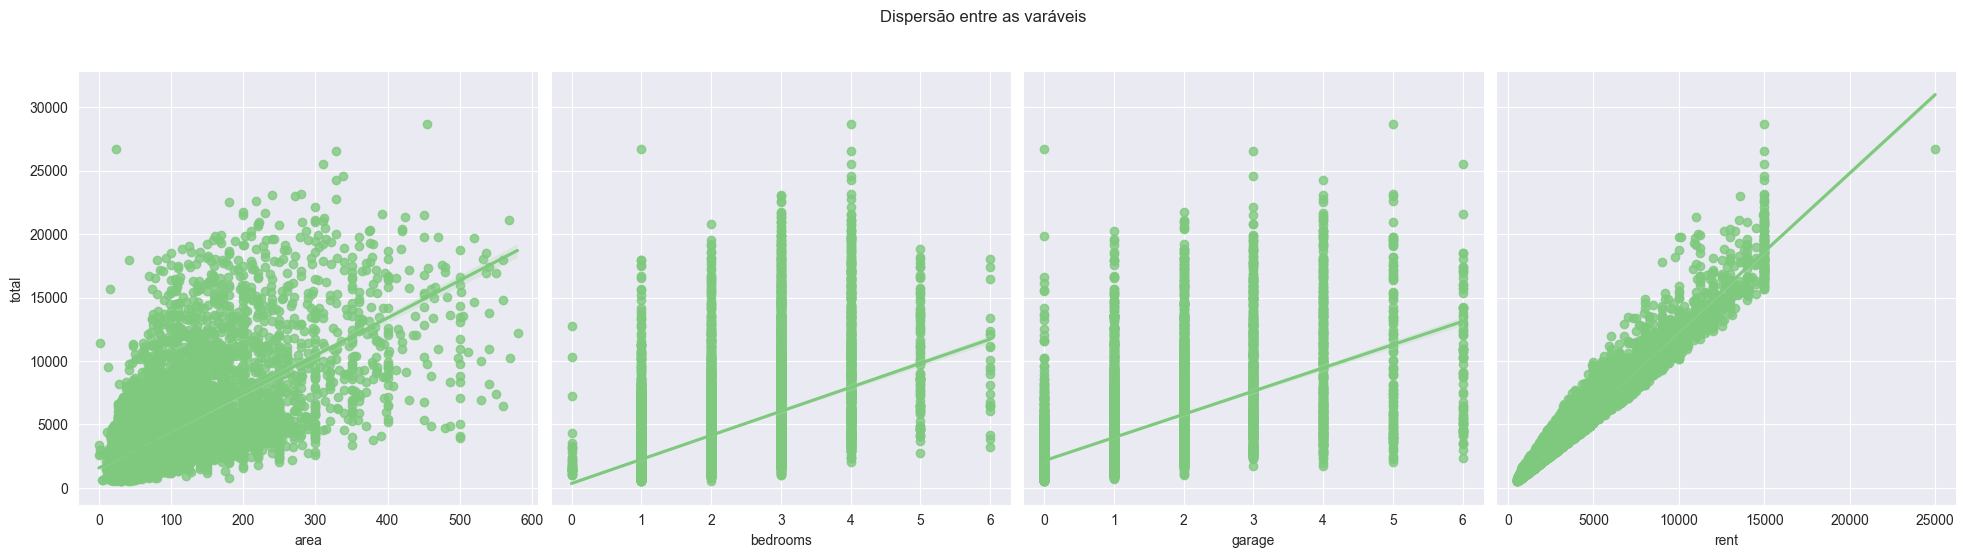

In [125]:
ax = sns.pairplot(dados, y_vars = 'total', x_vars = ['area', 'bedrooms', 'garage', 'rent'], height=5, kind = 'reg')
plt.suptitle('Dispersão entre as varáveis', fontsize = 12, y = 1.1)
plt.show()

### Avalie:
<ul style='font-size: 16px; line-height: 2; text-align: justify;'>
    <li>É possível identificar alguma relação linear entre as variáveis?</li>
    R: Sim, mas há tambem variáveis que indicam não haver homocedasticidade entre os dados, como os bairros.
    <li>A relação é positiva ou negativa?</li>
    R: Positiva, quando as variáveis explicaticas aumentam, a dependente aumenta também.
    <li>Compare com os resultados obtidos na matriz de correlação.</li>
    R: A dispersão entre os dados indica que a variância dos erros não é constante.
</ul>

# <font color='red' style='font-size: 30px;'>Transformando os Dados</font>
<hr style='border: 2px solid red;'>

## Distribuição Normal
<hr>

<p style='font-size: 18px; line-height: 2; margin: 10px 50px; text-align: justify;'>Testes paramétricos assumem que os dados amostrais foram coletados de uma população com distribuição de probabilidade conhecida. Boa parte dos testes estatísticos assumem que os dados seguem uma distribuição normal (t de Student, intervalos de confiança etc.).</p>


## Transformação de variáveis

#### Criação de uma coluna com códigos gerados para cada bairro diferente

In [15]:
label_encoder = LabelEncoder()
dados['district_encoded'] = label_encoder.fit_transform(dados['district'])


<Axes: title={'center': 'Distribuição de bairros'}, xlabel='Bairros', ylabel='Density'>

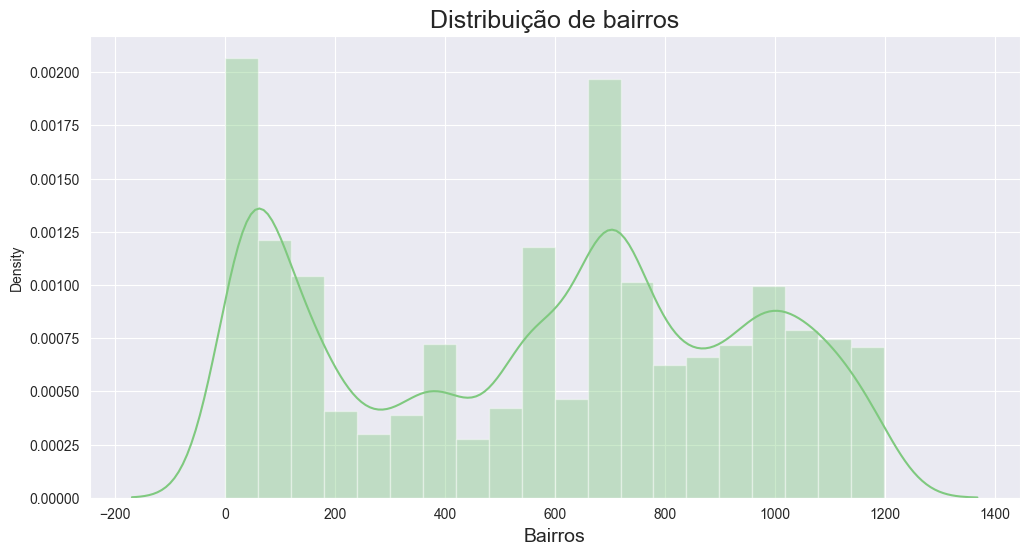

In [18]:
ax = sns.distplot(dados['district_encoded'], kde = True)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de bairros', fontsize=18)
ax.set_xlabel('Bairros', fontsize=14)
ax

#### Varica-se que os bairros trazem infomações que sujam o dataset, pois há nomes repetidos, escritos de forma minimamente diferente como um ponto final, que geram códigos diferentes, isso pode causar confusão no modelo de regressão.

In [21]:
# Imprimir bairros em formato de tabela para consulta
pd.set_option('display.max_rows', None)

print("\nCódigos\t\tBairros")
for codigo, nome in zip(dados['district_encoded'], dados['district']):
    print(f"{codigo}\t\t{nome}")


Códigos		Bairros
27		Belenzinho
984		Vila Marieta
668		Pinheiros
1097		Vila Ré
26		Bela Vista
43		Brás
42		Brooklin Paulista
67		Centro
669		Piqueri
780		Vila Aricanduva
729		Sé
729		Sé
738		Tatuapé
549		Lauzane Paulista
379		Jardim Paraventi
48		Cambuci
550		Liberdade
550		Liberdade
105		Cidade Monções
1195		Água Branca
563		Mooca
729		Sé
79		Chácara Inglesa
1005		Vila Moreira
146		Gopoúva
468		Jardim São Savério
759		Vila Amalia (zona Norte)
67		Centro
712		Saúde
678		Quarta Parada
700		Santa Efigênia
585		Paraíso do Morumbi
74		Chora Menino
992		Vila Medeiros
928		Vila Guarani(zona Leste)
43		Brás
22		Barra Funda
784		Vila Augusta
1037		Vila Olímpia
26		Bela Vista
846		Vila Celeste
291		Jardim Independência
43		Brás
738		Tatuapé
816		Vila Buarque
1174		Vila Vivaldi
813		Vila Brasílio Machado
837		Vila Carlos de Campos
1081		Vila Prudente
766		Vila Andrade
54		Campos Elíseos
1017		Vila Nivi
846		Vila Celeste
1044		Vila Palmeiras
674		Ponte Grande
985		Vila Marina
389		Jardim Pereira

In [23]:
dados.drop('district_encoded', axis = 1, inplace = True)

In [37]:
bairro_repetido = ['alphaville', 'jardimamerica', 'vilaolimpia', 'moema', 'pinheiros', 'tatuape']

def limpar_nome_bairro(nome):
    nome = nome.lower()
    nome = unidecode(nome)  # Aqui, estamos chamando a função unidecode do módulo unidecode
    nome = re.sub(r'\s+', '', nome)
    if nome.endswith('.'):
        nome = nome[:-1]  # Remove o último caractere se for um ponto final
    
    for bairro in bairro_repetido:
        if bairro in nome:
            return bairro
    return nome

dados['district'] = dados['district'].apply(limpar_nome_bairro)
dados['district'].nunique()


1069

In [38]:
district_counts = dados['district'].value_counts().sort_index()
district_counts_df = district_counts.reset_index()
district_counts_df.columns = ['District', 'Count']
print(district_counts_df)

                                      District  Count
0                                    aclimacao     50
1                                     adalgisa      4
2                                   aguabranca     45
3                                     aguafria     20
4                                    aguafunda      1
5                                     aguarasa     19
6                                   alphaville     94
7                               altodaboavista      4
8                                   altodalapa     15
9                                  altodamooca     34
10                                  altodopari      2
11                              americanopolis     11
12                                    anchieta      4
13                                  aricanduva      1
14                                  arturalvim      4
15                                      ayrosa      2
16                                   bandeiras      2
17                          

In [39]:
label_encoder = LabelEncoder()
dados['district_encoded'] = label_encoder.fit_transform(dados['district'])

### Criação de colunas true/false para classificar o tipo de imóvel

In [41]:
dados = pd.get_dummies(dados, columns=['type'], drop_first=False)

## Aplicando a transformação logarítmica aos dados do *dataset*

https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.log.html

In [42]:
dados['log_total'] = np.log(dados['total'])
dados['log_area'] = np.log(dados['area'] + 1) # +1 para evitar log de zero, pois tende ao infinito
dados['log_bedrooms'] = np.log(dados['bedrooms'] + 1) # +1 para evitar log de zero, pois tende ao infinito
dados['log_garage'] = np.log(dados['garage'] + 1) # +1 para evitar log de zero, pois tende ao infinito
dados['log_rent'] = np.log(dados['rent'])


In [43]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  11657 non-null  object 
 1   district                 11657 non-null  object 
 2   area                     11657 non-null  int64  
 3   bedrooms                 11657 non-null  int64  
 4   garage                   11657 non-null  int64  
 5   rent                     11657 non-null  int64  
 6   total                    11657 non-null  int64  
 7   district_encoded         11657 non-null  int32  
 8   type_Apartamento         11657 non-null  bool   
 9   type_Casa                11657 non-null  bool   
 10  type_Casa em condomínio  11657 non-null  bool   
 11  type_Studio e kitnet     11657 non-null  bool   
 12  log_total                11657 non-null  float64
 13  log_area                 11657 non-null  float64
 14  log_bedrooms          

## Transformação das colunas booleanas do dataset em inteiros, para que seja consideradas na estimação do código de regressão linear

In [44]:
dados[['type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet']] = dados[['type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet']].astype(int)

In [45]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11657 entries, 0 to 11656
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  11657 non-null  object 
 1   district                 11657 non-null  object 
 2   area                     11657 non-null  int64  
 3   bedrooms                 11657 non-null  int64  
 4   garage                   11657 non-null  int64  
 5   rent                     11657 non-null  int64  
 6   total                    11657 non-null  int64  
 7   district_encoded         11657 non-null  int32  
 8   type_Apartamento         11657 non-null  int32  
 9   type_Casa                11657 non-null  int32  
 10  type_Casa em condomínio  11657 non-null  int32  
 11  type_Studio e kitnet     11657 non-null  int32  
 12  log_total                11657 non-null  float64
 13  log_area                 11657 non-null  float64
 14  log_bedrooms          

In [46]:
dados.describe()

,area,bedrooms,garage,rent,total,district_encoded,type_Apartamento,type_Casa,type_Casa em condomínio,type_Studio e kitnet,log_total,log_area,log_bedrooms,log_garage,log_rent
count,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000,11657.000000
mean,84.655658,1.966286,1.060393,3250.814789,4080.030625,500.536931,0.617140,0.243716,0.020674,0.118470,8.069354,4.202384,1.039955,0.591621,7.848147
std,74.020536,0.931313,1.132349,2650.711557,3352.480274,329.331697,0.486105,0.429342,0.142298,0.323177,0.675153,0.664351,0.306689,0.504703,0.660995
min,0.000000,0.000000,0.000000,500.000000,509.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.232448,0.000000,0.000000,0.000000,6.214608
25%,40.000000,1.000000,0.000000,1590.000000,1996.000000,143.000000,0.000000,0.000000,0.000000,0.000000,7.598900,3.713572,0.693147,0.000000,7.371489
50%,60.000000,2.000000,1.000000,2415.000000,3057.000000,560.000000,1.000000,0.000000,0.000000,0.000000,8.025189,4.110874,1.098612,0.693147,7.789455
75%,96.000000,3.000000,2.000000,3800.000000,4774.000000,763.000000,1.000000,0.000000,0.000000,0.000000,8.470940,4.574711,1.386294,1.098612,8.242756
max,580.000000,6.000000,6.000000,25000.000000,28700.000000,1068.000000,1.000000,1.000000,1.000000,1.000000,10.264652,6.364751,1.945910,1.945910,10.126631


### Verificação se o log de preços de alugueis totais se comporta com uma distribuição simetrica normal

O resultado parece muito mais ajustado agora

<Axes: title={'center': 'Distribuição de Frequências'}, xlabel='log do Preço dos Imóveis', ylabel='Density'>

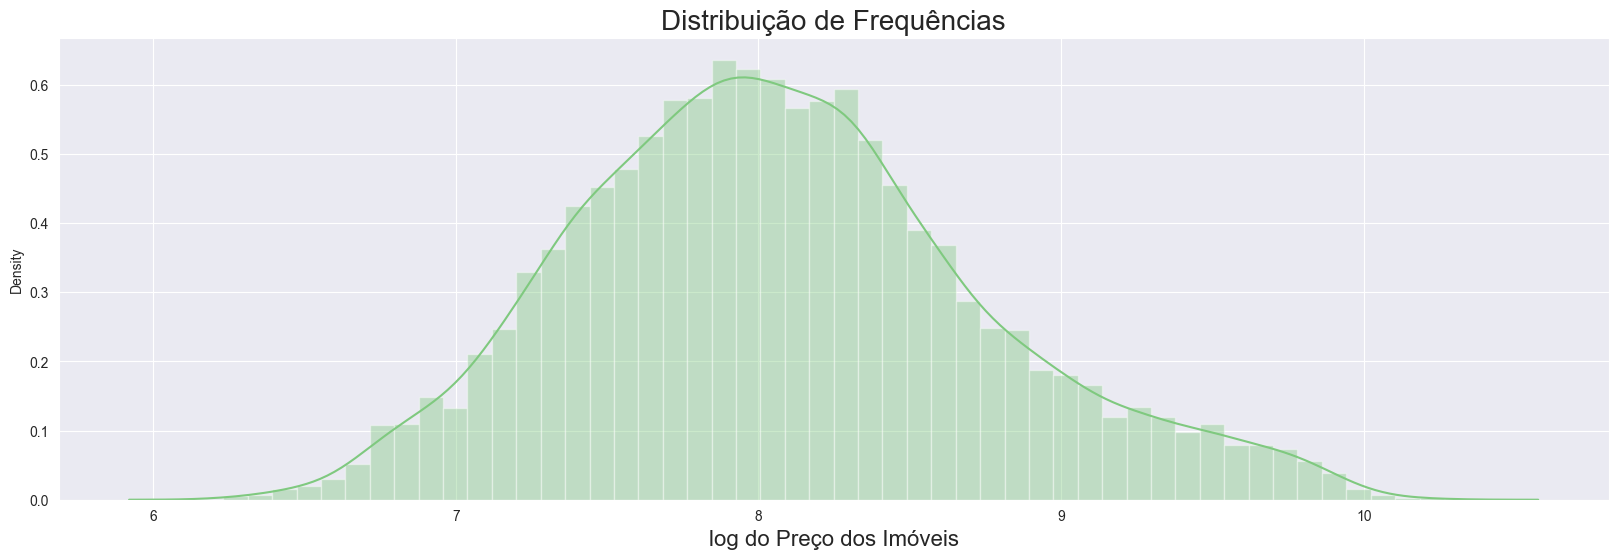

In [47]:
ax = sns.distplot(dados['log_total'], kde=True)
ax.figure.set_size_inches(20, 6)
ax.set_title('Distribuição de Frequências', fontsize=20)
ax.set_xlabel('log do Preço dos Imóveis', fontsize=16)
ax

# <font color='red' style='font-size: 30px;'>3.2 Verificando Relação Linear</font>
<hr style='border: 2px solid red;'>

## Gráficos de dispersão entre as variáveis transformadas do dataset

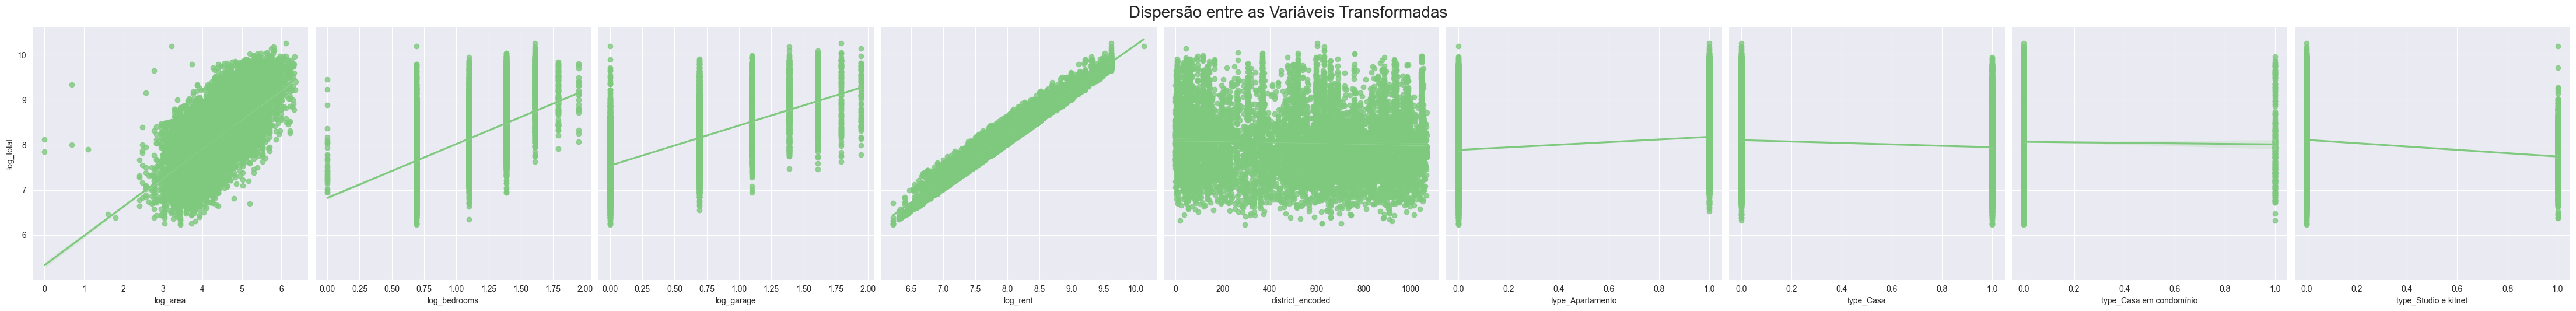

In [48]:
ax = sns.pairplot(dados, y_vars='log_total', x_vars=['log_area', 'log_bedrooms', 'log_garage','log_rent','district_encoded','type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet'], kind='reg',height=5)
ax.fig.suptitle('Dispersão entre as Variáveis Transformadas', fontsize=20, y=1.05)
ax

# <font color='red' style='font-size: 30px;'>Estimando um Modelo de Regressão Linear</font>
<hr style='border: 2px solid red;'>

## Criando uma Series (pandas) para armazenar a variável dependente (y)

In [49]:
y = dados['log_total']

## Criando um DataFrame (pandas) para armazenar as variáveis explicativas (X)

In [50]:
# não usaremos a variávels 'rent' pois apresenta uma forte correlação com as outras variáveis explicativas 
#e 'district_encoded' devido a sujeira das informções como bairros escritos de forma diferente sendo considerados como diferentes, ex: 'Se' e 'Sé', 'Alphavile' ou 'Alphavile.'

X = dados[['log_area', 'log_bedrooms', 'log_garage','district_encoded','type_Apartamento', 'type_Casa', 'type_Casa em condomínio', 'type_Studio e kitnet']]

## Criando os datasets de treino e de teste

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2811)

## Estimando o modelo com statsmodels

In [52]:
import statsmodels.api as sm
X_train_com_constante = sm.add_constant(X_train)

In [53]:
modelo = sm.OLS(y_train, X_train_com_constante, hasconst=True).fit()

# <font color='red' style='font-size: 30px;'>Avaliando o Modelo Estimado</font>
<hr style='border: 2px solid red;'>

## Avaliando as estatísticas de teste do modelo
Teste de significância conjunta dos parâmetros

    Prob (F-statistic) <= 0.05 (OK)

Teste de significância individual dos parâmetros

    P>|t| <= 0.05 (OK)

In [54]:
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:              log_total   R-squared:                       0.636
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     2034.
Date:                Sat, 01 Jun 2024   Prob (F-statistic):               0.00
Time:                        18:04:09   Log-Likelihood:                -4260.9
No. Observations:                8159   AIC:                             8538.
Df Residuals:                    8151   BIC:                             8594.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

# <font color='red' style='font-size: 30px;'>Estimando o Modelo com os Dados de Treino</font>
<hr style='border: 2px solid red;'>

## Instanciando a classe *LinearRegression()*

In [55]:
modelo = LinearRegression()

## Utilizando o método *fit()* para estimar o modelo linear utilizando os dados de TREINO (y_train e X_train)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit

In [56]:
modelo.fit(X_train, y_train)

LinearRegression()

## Obtendo o coeficiente de determinação (R²) do modelo estimado com os dados de TREINO

### Coeficiente de Determinação - R²

O coeficiente de determinação (R²) é uma medida resumida que diz quanto a linha de regressão ajusta-se aos dados. É um valor entra 0 e 1.

$$R^2(y, \hat{y}) = 1 - \frac {\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2}{\sum_{i=0}^{n-1}(y_i-\bar{y}_i)^2}$$

In [57]:
print('R² = {}'.format(modelo.score(X_train, y_train).round(2)))

R² = 0.64


## Gerando previsões para os dados de TESTE (X_test) utilizando o método *predict()*

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.predict

In [58]:
y_previsto = modelo.predict(X_test)
#X_test.describe()

## Obtendo o coeficiente de determinação (R²) para as previsões do nosso modelo

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html#sklearn.metrics.r2_score

In [59]:
print('R² = {}'.format(metrics.r2_score(y_test, y_previsto).round(2)))

R² = 0.62


# <font color='red' style='font-size: 30px;'>Métricas de Regressão</font>
<hr style='border: 2px solid red;'>

## Métricas da regressão
<hr>

fonte: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

Algumas estatísticas obtidas do modelo de regressão são muito úteis como critério de comparação entre modelos estimados e de seleção do melhor modelo, as principais métricas de regressão que o scikit-learn disponibiliza para modelos lineares são as seguintes:

### Erro Quadrático Médio

Média dos quadrados dos erros. Ajustes melhores apresentam $EQM$ mais baixo.

$$EQM(y, \hat{y}) = \frac 1n\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2$$

### Raíz do Erro Quadrático Médio

Raíz quadrada da média dos quadrados dos erros. Ajustes melhores apresentam $\sqrt{EQM}$ mais baixo.

$$\sqrt{EQM(y, \hat{y})} = \sqrt{\frac 1n\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2}$$

### Coeficiente de Determinação - R²

O coeficiente de determinação (R²) é uma medida resumida que diz quanto a linha de regressão ajusta-se aos dados. É um valor entra 0 e 1.

$$R^2(y, \hat{y}) = 1 - \frac {\sum_{i=0}^{n-1}(y_i-\hat{y}_i)^2}{\sum_{i=0}^{n-1}(y_i-\bar{y}_i)^2}$$

In [60]:
EQM = metrics.mean_squared_error(y_test, y_previsto).round(2)
REQM = np.sqrt(metrics.mean_squared_error(y_test, y_previsto)).round(2)
R2 = metrics.r2_score(y_test, y_previsto).round(2)

pd.DataFrame([EQM, REQM, R2], index = ['EQM', 'REQM', 'R2'], columns = ['Métricas'])

,Métricas
EQM,0.17
REQM,0.41
R2,0.62


# <font color='red' style='font-size: 30px;'>Análises Gráficas dos Resultados do Modelo</font>
<hr style='border: 2px solid red;'>

## Gerando as previsões do modelo para os dados de TREINO

In [61]:
y_previsto_train = modelo.predict(X_train)

## Gráfico de dispersão entre valor estimado e valor real

https://seaborn.pydata.org/generated/seaborn.scatterplot.html

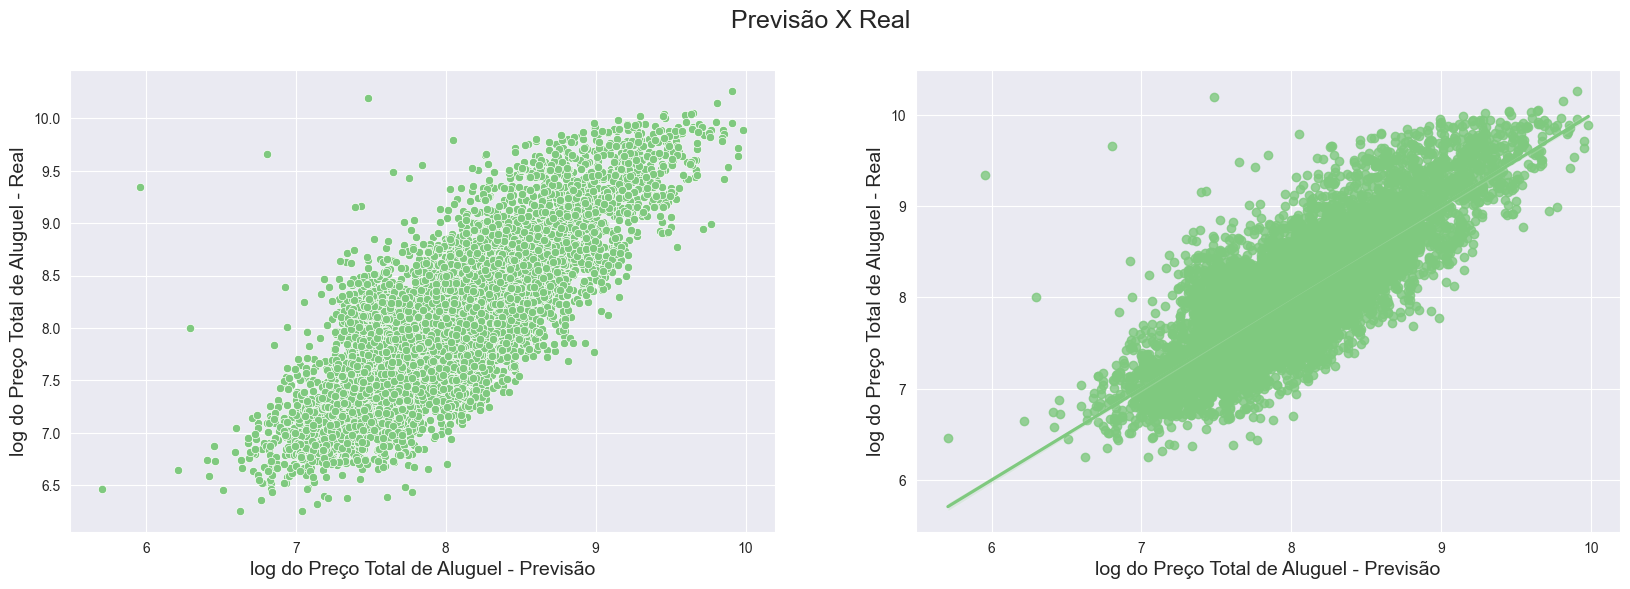

In [62]:
fig, ax = plt.subplots(1,2, figsize=(20, 6))
fig.suptitle('Previsão X Real', fontsize=18)

sns.scatterplot(x=y_previsto_train, y=y_train, ax=ax[0])
# ax[0].set_title('Previsão X Real', fontsize=18)
ax[0].set_xlabel('log do Preço Total de Aluguel - Previsão', fontsize=14)
ax[0].set_ylabel('log do Preço Total de Aluguel - Real', fontsize=14)


sns.regplot(x=y_previsto_train, y=y_train, ax=ax[1])
# ax[1].set_title('Previsão X Real', fontsize=18)
ax[1].set_xlabel('log do Preço Total de Aluguel - Previsão', fontsize=14)
ax[1].set_ylabel('log do Preço Total de Aluguel - Real', fontsize=14)

plt.show()

## Obtendo os resíduos

In [63]:
residuos = y_train - y_previsto_train

## Plotando a distribuição de frequências dos resíduos

<Axes: title={'center': 'Distribuição de Frequências dos Resíduos'}, xlabel='log do Preço', ylabel='Density'>

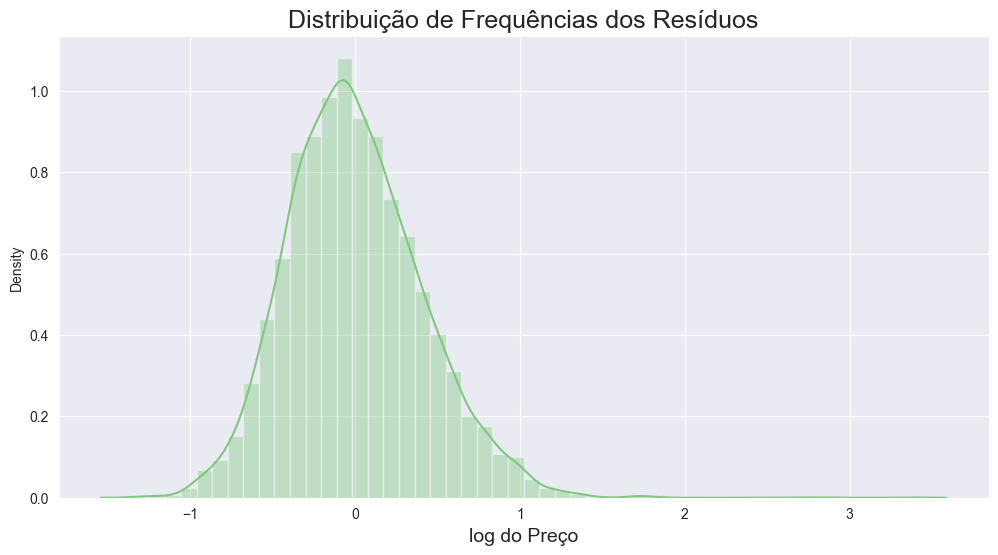

In [64]:
ax = sns.distplot(residuos)
ax.figure.set_size_inches(12, 6)
ax.set_title('Distribuição de Frequências dos Resíduos', fontsize=18)
ax.set_xlabel('log do Preço', fontsize=14)
ax

# <font color='red' style='font-size: 30px;'>Interpretação dos Coeficientes Estimados</font>
<hr style='border: 2px solid red;'>

## Obtendo o intercepto do modelo

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>O <b>intercepto</b> representa o efeito médio em $Y$ (Preço do Imóveis) tendo todas as variáveis explicativas excluídas do modelo. No caso do modelo log-linear este coeficiente deve ser transformado com o uso da função exponencial para ser apresentado em R$.</p>

In [65]:
modelo.intercept_

5.245726903920669

In [66]:
np.exp(modelo.intercept_)

189.75369781665623

## Obtendo os coeficientes de regressão

<p style='font-size: 20px; line-height: 2; margin: 10px 50px; text-align: justify;'>Um aspecto interessante do modelo log-linear, que o tornou muito utilizado nos trabalhos aplicados, é que os coeficientes angulares medem as elasticidades de Y em relação as varáveis explicativas, isto é, a variação percentual de Y correspondente a uma dada variação percentual (pequena) nas variáveis explicativas (X).</p>

In [67]:
modelo.coef_

array([ 6.27584448e-01, -1.04953301e-01,  4.77026981e-01, -1.20998656e-04,
        2.08404741e-01, -3.84646237e-01, -1.84804288e-01,  3.61045785e-01])

## Confirmando a ordem das variáveis explicativas no DataFrame

In [68]:
X.columns

Index(['log_area', 'log_bedrooms', 'log_garage', 'district_encoded',
       'type_Apartamento', 'type_Casa', 'type_Casa em condomínio',
       'type_Studio e kitnet'],
      dtype='object')

## Criando uma lista com os nomes das variáveis do modelo

In [69]:
index = ['Intercepto','Área (m²)', 'Quantidade de quartos','Quantidade de garagens','Código do bairro','É apartamento? (0 ou 1)','É Casa? (0 ou 1)','É casa em condomínio? (0 ou 1)', 'É Studio ou Kitnet? (0 ou 1)']

## Criando um DataFrame para armazenar os coeficientes do modelo

https://docs.scipy.org/doc/numpy/reference/generated/numpy.append.html?#numpy.append

In [70]:
pd.DataFrame(data=np.append(modelo.intercept_, modelo.coef_), index=index, columns=['Parâmetros'])

,Parâmetros
Intercepto,5.245727
Área (m²),0.627584
Quantidade de quartos,-0.104953
Quantidade de garagens,0.477027
Código do bairro,-0.000121
É apartamento? (0 ou 1),0.208405
É Casa? (0 ou 1),-0.384646
É casa em condomínio? (0 ou 1),-0.184804
É Studio ou Kitnet? (0 ou 1),0.361046


# <font color='red' style='font-size: 30px;'>Obtendo Previsões Pontuais</font>
<hr style='border: 2px solid red;'>

## Criando um simulador simples

Crie um simulador que gere estimativas de preço a partir de um conjunto de informações de um imóvel.

In [72]:
area = 60           #Área (m²)
qtd_quartos = 1     #Quantidade de quartos
qtd_garagens = 0    # Quantidade de garagens
cod_bairro = 79     # O código do bairro (Verificar tabela)
apartamento = 1      #É apartamento? (0 ou 1)
casa = 0            # É Casa? (0 ou 1)'
casa_condominio = 0  # É casa em condomínio? (0 ou 1)
studio_kitnet = 0    # É Studio ou Kitnet? (0 ou 1)


entrada = [[np.log(area + 1), np.log(qtd_quartos + 1), np.log(qtd_garagens + 1), cod_bairro, apartamento, casa, casa_condominio, studio_kitnet]]

print('Preço total do aluguel = R$ %s' % np.exp(modelo.predict(entrada)[0]).round(2))

Preço total do aluguel = R$ 2840.53


Tabela para consulta do bairro pelo seu respectivo código **todos os nomes estão em ordem alfabetica, em minúsculo, sem acentos e concatenados**. Ex: Alto da Boa Vista = altodaboavista

In [78]:
pd.set_option('display.max_rows', None)

correspondencias = set()

for codigo, nome in zip(dados['district_encoded'], dados['district']):
    correspondencias.add((codigo, nome))

correspondencias_ordenadas = sorted(correspondencias, key=lambda x: x[1])

print("\nCódigos\t\tBairros")
for codigo, nome in correspondencias_ordenadas:
    print(f"{codigo}\t\t{nome}")


Códigos		Bairros
0		aclimacao
1		adalgisa
2		aguabranca
3		aguafria
4		aguafunda
5		aguarasa
6		alphaville
7		altodaboavista
8		altodalapa
9		altodamooca
10		altodopari
11		americanopolis
12		anchieta
13		aricanduva
14		arturalvim
15		ayrosa
16		bandeiras
17		barrafunda
18		barrobranco(zonanorte)
19		belaalianca
20		belavista
21		belem
22		belenzinho
23		bethavillei
24		boacava
25		boavista
26		bolsaodointerlagos
27		bomretiro
28		bonfim
29		bortolandia
30		bosquedasaude
31		bras
32		brasilandia
33		brooklin
34		brooklinnovo
35		brooklinpaulista
36		burgopaulista
37		bussocaba
38		butanta
39		cambuci
40		campanario
41		campestre
42		campininha
43		campobelo
44		campogrande
45		camposeliseos
46		cangaiba
47		canhema
48		caninde
49		capeladosocorro
50		carandiru
51		casabranca
52		casaverde
53		casaverdealta
54		casaverdemedia
55		catumbi
56		caxingui
57		centro
58		centrocapital
59		centrocomercialjubran
60		centroempresarialtambore
61		centrohistoricodesaopaulo
62		cerqueiracesar
63		

# <font color='red' style='font-size: 30px;'>Salvando e Carregando o Modelo Estimado</font>
<hr style='border: 2px solid red;'>

## Salvando o modelo estimado

In [79]:
output = open('modelo_preco_total_aluguel','wb')
pickle.dump(modelo, output)
output.close()